
# **Project Report: Deep Learning Based Face Mask Recognition**

#### ELEC-435: Deep Learning: Foundations, Applications, and Algorithms

[Project Github](https://github.com/GuoJiaqi-1020/EE-435-DL-Final-Project)






## **Background and Motivattion**

Until **February 2**, there have been 386,548,962 confirmed cases of COVID-19 worldwide and droplet transmission is the main cause of transmission. Traditional labor-based supervision system will cause a great waste of labour resource. Thanks to advances in computer science and artificial intelligence in recent years, we can use image-based deep learning techniques to solve this problem. That is, collecting facial images through cameras and performing masking wearing recognition with specific deep learning frameworks. In this way, labor and time costs can be saved, and the spread of the virus will be more effectively controlled.

## **Data Augmentation with GAN**

Getting larger data sets is one of the most reliable ways to improve the performance of machine learning algorithms. In some cases, adding generated or synthesized data can also improve performance. The most common approach is to apply some basic transformations to existing data. In the example of image classification, we know, for example, that after moving or flipping an image of a cat, it is still an image of a cat. Therefore, in order to get the best classification results, we usually carry out some **image processing operations** on our data set, such as flipping, rotating, changing colors, etc.

**Generative adversarial networks (GANs)**, which were developed by Ian Goodfellow in 2014, have recently become an active topic in machine learning research. GAN is an unsupervised generation model that implicitly learns the underlying distribution. In the GAN framework, the learning process is a minimax game between two networks, a generator that generates synthetic data for a given random noise vector, and a discriminator that distinguishes the synthetic data of real data from that of the generator.We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. The application of GANs in many fields has achieved remarkable results, especially in the field of computer vision. In this article, we'll explore a less flashy but influential use case of GANs, **data augmentation** to improve classifier performance in supervised learning.







Grant Google Colab access to our shared Google Drive.

In [ ]:
import os 
from google.colab import drive
drive.mount('/content/drive')
root_path = "/content/drive/My Drive/EE_435_project/"

os.chdir(root_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load all the necessary packages, recheck the version of **Pytorch=1.10.0+cu111**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as tf 
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid,save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import pandas as pd
import datetime
import argparse
from PIL import Image
from tqdm.notebook import tqdm
from models import CNNModel
from train_test import train, test
from dataset import get_train_val_test_dataloader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Finding an available device:{}".format(device))
print("Finish loading packages, the Pytorch version is:{}".format(torch.__version__))

Finding an available device:cuda
Finish loading packages, the Pytorch version is:1.10.0+cu111


### **Parameter Speccification**
All the variables designed for network training are defined here:

In [ ]:
# Use argparse to define the parameters
parser = argparse.ArgumentParser(description='Specifies parameters for data augmentation')
parser.add_argument('--workers', type=int, default=2, help='Turn on multi-process data loading with the specified number of loader worker processes')
parser.add_argument('--data_path', type=str, default="/content/drive/My Drive/EE_435_project/Data/dataset/", help='Enter your dataset directory')
parser.add_argument('--model_path', type=str, default="/content/drive/My Drive/EE_435_project/trained_model/", help='Enter your model directory')
parser.add_argument('--ms', type=tuple, default=((0.5,0.5,0.5),(0.5,0.5,0.5)), help='Parameter for tf.Normalize')
parser.add_argument('--trained_generator', type=str, default="Gen_final_transfer.pkl", 
                    help='Other Option: "Gen_celeba.pkl"/"Gen_final_transfer.pkl"/"Gen_nomask.pkl"')
parser.add_argument('--image_size', type=int, default=64, help='The image size for both input and output')
parser.add_argument('--batch_size', type=int, default=128, help='Training batch size')
parser.add_argument('--store_the_trained_model', type=bool, default=False, help='Store the trained weight')
parser.add_argument('--lr', type=int, default=0.0002, help='Learning rate of optimizer')
parser.add_argument('--epoch', type=int, default=200, help='Epoches of training')
parser.add_argument('--latent_size', type=int, default=128, help='Latent size')
args = parser.parse_known_args()[0]

latent_size=args.latent_size
batch_size=args.batch_size


### **Introduction to Dataset**

The dataset is named [**Face-Mask Recognition Dataset (FMRD)**](https://www.kaggle.com/hadjadjib/facemask-recognition-dataset) in which we attempted to offer more real-world face-mask recognition datasets. The Face Mask Detection and MaskedFace-Net datasets have been combined to contribute to achieving the FMRD. The FMRD contains 1500 images per class, making the dataset **total around 4,500 images**.

The particularity of the FMRD is that it contains the three classes describing diverse image faces with **correctly**, **incorrectly**, and **no mask worn**.

In [ ]:
dataset = ImageFolder(args.data_path,transform=tf.Compose([
                       tf.Resize(args.image_size),
                       tf.CenterCrop(args.image_size),
                       tf.ToTensor(),
                       tf.Normalize(*args.ms),
                       ]))         
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=args.workers)

print("In total {} images are loaded from the dataset".format(len(dataset)))

In total 4559 images are loaded from the dataset


In [ ]:
def denormalized(img):
    return img * args.ms[1][0] + args.ms[0][0]

torch.Size([128, 3, 64, 64])


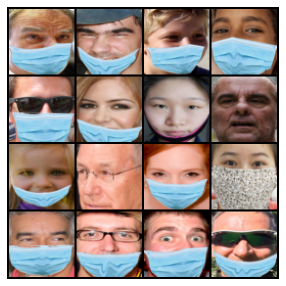

In [ ]:
image,_ = next(iter(dataloader))
print(image.shape)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(make_grid(denormalized(image)[:16],nrow=4).permute(1,2,0))

In [ ]:
def deviceLoaderfunc(data,device):
    if isinstance(data,(list,tuple)):
        return [deviceLoaderfunc(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
def generate_new_sample(generator_structure,trained_model):
  latent_noise = torch.randn(64, latent_size, 1, 1, device=device)
  os.chdir(args.model_path)
  generator_structure.load_state_dict(torch.load(trained_model))
  gen_image=generator_structure(latent_noise)[:16]
  fimg_name='images-gnereate.png'
  os.chdir(root_path)
  if not os.path.exists('new_gen_img'):
    os.makedirs('new_gen_img')
  save_image(denormalized(gen_image),os.path.join('new_gen_img',fimg_name),nrow=4)

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield deviceLoaderfunc(b, self.device)
            
    def __len__(self):
        return len(self.dl)


In [ ]:
dataloader = DeviceDataLoader(dataloader, device)

### **Define the Discriminator**

For discriminator($D$), we will update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:

$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

The structure of the discriminator is illustrated below:

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = deviceLoaderfunc(discriminator, device)
print(discriminator)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

### **Define the Generator**

For generator($G$), we will update it to maximize the probability of the discriminator making the incorrect choice on generated data:

$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

The structure of the generator is illustrated below:

In [ ]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)   

In [ ]:
generator = deviceLoaderfunc(generator, device)
print(generator)
os.chdir(args.model_path)
if os.path.exists(args.trained_generator):
  generator.load_state_dict(torch.load(args.trained_generator))
  print("Trained weight applied")

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)


### **Transfer Learning of Generator in GAN**

#### **Why Transfer Learning?**

In the process of training, we found that due to the small amount of data, the loss function of the generator **did not converge well**, that is to say, our generator could not learn enough image features to generate accurate and beautiful images. Also, it causes the discriminator to have loss close to zero (because the discriminator can easily distinguish the generated image from the real one), which makes it even harder to update the weight of discriminator. In order to solve this problem, we implement the theory of **transfer learning** in our project, through the introduction of pre-training model, greatly improve the performance of the model.



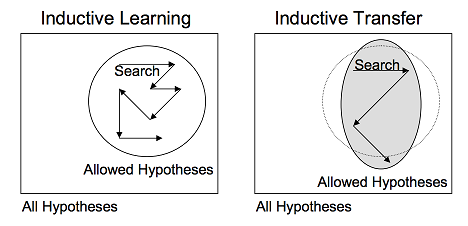

#### **How to Get the Base Model?**

In **transfer learning**, we first train **a base network** on a base dataset and a base task, then we fine-tune the features learned, or transfer them to **a second target network**, and train the network with the target dataset and the target task. This process works if the features are generalized, that is, they are applicable to both the base task and the target task, rather than being specific to the base task.

In this project, we used [**the CelebFace Attributes (CelebA) Dataset**](https://www.kaggle.com/jessicali9530/celeba-dataset/) to pre-train our base model. This dataset contains over 200k images of celebrities with 40 binary attribute annotations. We believe that this dataset should enable our network to learn some basic generalization features due to the commonality of face images.

#### **The Transfer Learning Pipline**

The figure below shows our transfer learning process. First, we use CelebA dataset to pre-train the network and get the initial **basic model**. Later, we used Nomasking Image in the target dataset(FMRD) to train the model for the second time. Here, in order to avoid the loss value of the discriminator becoming 0, we only use the pre-trained generator model and **discard the pre-trained discriminator model**. And in every single epoch, the weights of the generator are updated twice while the discriminator is only updated once. Finally, we train the network with the entire target dataset(FMRD) and follow the same training procedure (discarding pre-trained discriminator parameters and updating generator parameters more frequently).

The parameter setting of our training are illustrated in the code below:

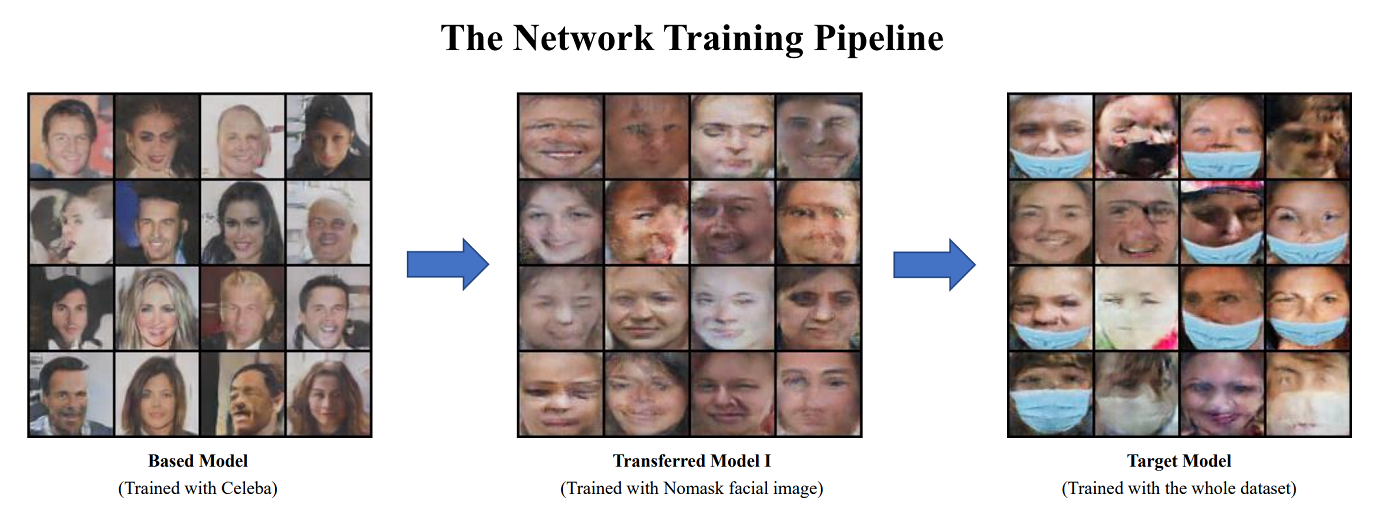

For both generator and discriminator, we use the `binary_cross_entropy` function as the loss function.

In [ ]:
def train_discriminator(r_images,optimizer):
    optimizer.zero_grad()
    r_preds=discriminator(r_images)
    r_targets=torch.ones(r_images.size(0),1,device=device)
    r_loss = F.binary_cross_entropy(r_preds, r_targets) 
    r_score = torch.mean(r_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    g_images = generator(latent)
   
    g_targets = torch.zeros(g_images.size(0), 1, device=device)
    g_preds = discriminator(g_images)
    g_loss = F.binary_cross_entropy(g_preds, g_targets)
    g_score = torch.mean(g_preds).item()

    loss = r_loss + g_loss
    loss.backward()
    optimizer.step()
    
    return loss.item(), r_score,g_score

In [ ]:
def train_generator(optimizer):
    optimizer.zero_grad()
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    g_images = generator(latent)
    
    preds = discriminator(g_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

For the Adam optimizer, we initialize a learning rate of $0.0002$, and $\beta_1=0.5$, $\beta_2=0.999$.

In [ ]:
latent_noise = torch.randn(64, latent_size, 1, 1, device=device)
os.makedirs('new_gen_img', exist_ok=True)
def fit(epochs, lr, index=1):
    
    torch.cuda.empty_cache()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        lr=lr*0.995
        d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
        for r_images, _ in tqdm(dataloader):
            loss_d, r_score, g_score = train_discriminator(r_images, d_optimizer)
            loss_g = train_generator(g_optimizer)
            loss_g = train_generator(g_optimizer)
        
        g_images=generator(latent_noise)
        if epoch%5==0:
            fimg_name='images-{0:0=4d}.png'.format(epoch+index,)
            save_image(denormalized(g_images),os.path.join('new_gen_img',fimg_name),nrow=8)
            
            print(" {} out of {} epochs, loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, epochs, loss_g, loss_d, r_score, g_score))

For the base model (CelebA), we only trained it for **20 epoches**. And for the other two models (FMRD), we trained each model for **200 epoches**.

In [ ]:
# Save the trained model
records=fit(args.epoch,args.lr)
if args.store_the_trained_model:
  saved_name='trained_model'+datetime.datetime.now().strftime('%Y-%m-%d')+".pkl"
  torch.save(generator.state_dict(),"Gen_"+saved_name)
  torch.save(discriminator.state_dict(),"Dis_"+saved_name)

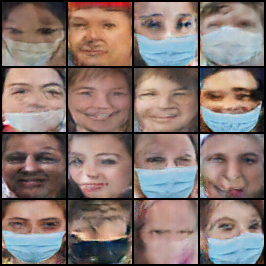

In [ ]:
generate_new_sample(generator_structure=generator, trained_model=args.trained_generator)
Image.open('./new_gen_img/images-gnereate.png')

## Your Part

把这几个模型给运行了，然后对比对比，做一点结果分析，输出不要有训练过程，最后做个总结，完成！

In [ ]:
class arguments:
    def __init__(self,
                 data_dir='../Data/Pixel50/',
                 train_val_proportion=0.9,
                 train_proportion=0.7,
                 seed=42,
                 epochs=10,
                 batch_size=32,
                 lr=1e-4,
                ):
        self.data_dir = data_dir
        # 0.9: train : val : test = 0.7 : 0.2 : 0.1
        self.train_val_proportion = train_val_proportion
        self.train_proportion = train_proportion
        self.seed = seed
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def main(model,args):
    train_dataloader, val_dataloader, test_dataloader = get_train_val_test_dataloader(args)
    print(f"Using {args.device} device")

    # training and validation
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    for t in range(args.epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(args, train_dataloader, model, loss_fn, optimizer)
        val_loss, correct = test(args, val_dataloader, model, loss_fn)
        print('training loss: {}, val loss: {}, correct: {}'.format(train_loss, val_loss, correct))
    print("Done!")

    # test
    test_loss, correct = test(args, test_dataloader, model, loss_fn)
    print('\n\n ############## \n test loss: {} correct: {}'.format(test_loss, correct))

In [ ]:
# basic CNN model (Alexnet)
args = arguments()
model = CNNModel().to(args.device)
main(model,args)

In [ ]:
# Resnet18
args = arguments()
resnet18 = models.resnet18()
main(resnet18,args)

In [ ]:
# vgg16 model
args = arguments()
vgg16 = models.vgg16()
main(vgg16,args)

In [ ]:
# efficientnet model
args = arguments()
efficientnet = models.efficientnet_b0()
main(efficientnet,args)

In [ ]:
# resnet18 with pretrained model
args = arguments(epochs=5)
resnet18 = models.resnet18(pretrained=True)
main(resnet18,args)